#### 超参数定义

In [35]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 512 # 每个小批量的大小
learning_rate = 3e-4 # 学习率
EPOCH = 20 # 训练轮数

#### 标准化操作&数据增强

定义标准化函数，将原始图像数据每个像素值0-255转换为服从均值为0，标准差为1的分布

同时对训练集进行随机裁剪和随机水平反转的数据增强

In [20]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#### 数据集加载

使用Torchvision加载CIFAR-10数据集

<img src="./image/CIFAR-10.png" width=512/>

In [37]:
from torchvision import datasets

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

#### 模型网络构建

首先定义一个基础残差块，内部前向传播路径为卷积->标准化->激活函数->卷积->标准化，最后输出$relu(H(x) = F(x) + x)$。

In [23]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)

        return out

ResNet18网络结构，输入通道数为3(RGB)，前向传播路径为卷积->标准化->激活函数->残差块*4->平均池化->特征图展平->全连接层->输出

在残差块前的部分可以理解为做了初步的特征提取。在残差块内部，由于特征图宽高及层数改变，故需要对每层的输入$x$进行变换，才能将其加到输出$F(x)$中

downsample定义了一个卷积核为1的操作，同时步长与残差块步长一致，故能变换输入特征图$x$为输出$F(x)$的形式

In [24]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [39]:
model = ResNet18(num_classes=10).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### 训练部分

流程：梯度置零->正向传播->损失计算->反向传播->参数更新

In [26]:
def train():
    model.train()
    loss_sum = 0
    for _, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs = inputs.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
    return loss_sum / train_loader.__len__()

#### 推理部分

只进行正向传播

In [27]:
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): # 测试集不用算梯度
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0) # 取出当前批次的总数
            correct += (predicted == labels).sum().item()
    return correct / total

#### 数据展示

EPOCH: 1 / 20    loss: 1.32531    acc on testset: 62.31%
EPOCH: 2 / 20    loss: 0.8457    acc on testset: 72.02%
EPOCH: 3 / 20    loss: 0.66131    acc on testset: 70.79%
EPOCH: 4 / 20    loss: 0.56202    acc on testset: 77.25%
EPOCH: 5 / 20    loss: 0.48985    acc on testset: 79.21%
EPOCH: 6 / 20    loss: 0.44156    acc on testset: 82.14%
EPOCH: 7 / 20    loss: 0.39869    acc on testset: 83.81%
EPOCH: 8 / 20    loss: 0.3668    acc on testset: 85.26%
EPOCH: 9 / 20    loss: 0.33103    acc on testset: 85.07%
EPOCH: 10 / 20    loss: 0.30615    acc on testset: 84.73%
EPOCH: 11 / 20    loss: 0.28485    acc on testset: 84.54%
EPOCH: 12 / 20    loss: 0.26719    acc on testset: 87.11%
EPOCH: 13 / 20    loss: 0.24728    acc on testset: 87.75%
EPOCH: 14 / 20    loss: 0.23267    acc on testset: 88.53%
EPOCH: 15 / 20    loss: 0.21836    acc on testset: 87.02%
EPOCH: 16 / 20    loss: 0.20369    acc on testset: 88.76%
EPOCH: 17 / 20    loss: 0.19438    acc on testset: 88.97%
EPOCH: 18 / 20    loss: 0

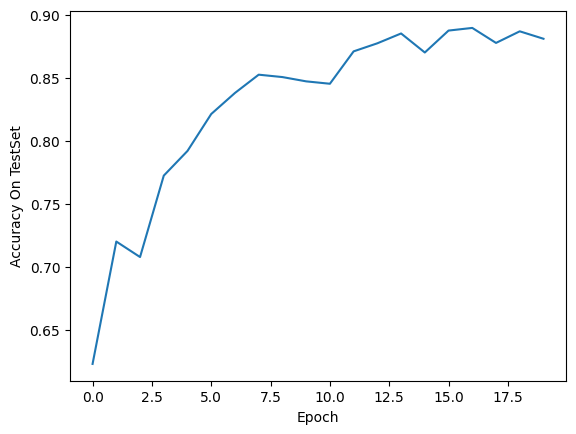

In [40]:
from matplotlib import pyplot as plt

if __name__ == '__main__':   #start
    acc_list_test = []
    for epoch in range(EPOCH):
        loss_train = train()
        acc_test = test()
        print(f"EPOCH: {epoch + 1} / {EPOCH}    loss: {round(loss_train, 5)}    acc on testset: {round(acc_test * 100, 2)}%")
        acc_list_test.append(acc_test)

    torch.save(model.state_dict(), "model.pth")

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()